# Analysis for figure 4

## Installations & Downloads

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pickle
import scipy
import pandas as pd
from scipy import stats
from scipy.stats import normaltest
import matplotlib as mpl
import itertools
from itertools import groupby

sys.path.append(os.path.abspath('../..'))

import warnings
warnings.simplefilter('ignore', pd.errors.DtypeWarning)
np.seterr(divide='ignore')
warnings.simplefilter("ignore")


import analysis.calc_single_cell_properties as calculator 
import analysis.utils as utils
import data_layer.utils as data_utils
from configuration import consts, params

# Load the data

In [2]:
scores_df_s3 = data_utils.get_scores_df_with_fusion()

In [21]:
# validate that all fusion-timing-tagged-cells are semi-manually tracked
no_data_tracks = []
untracked_cells_ids = []
for track_id in scores_df_s3["Spot track ID"].unique():
    track_data = scores_df_s3[(scores_df_s3["Spot track ID"]==track_id)]
    if len(track_data)<=1:
        if track_data["manual manual"].sum()==0:
            untracked_cells_ids.append(track_id)
        else:
            no_data_tracks.append(track_id)
        
print("number of fusion annotated cells: ", scores_df_s3["Spot track ID"].nunique())
print(f"number of untracked cells: {len(untracked_cells_ids)}/{scores_df_s3['Spot track ID'].nunique()}")
print(f"number of no data cells: {len(no_data_tracks)}/{scores_df_s3['Spot track ID'].nunique()}")
print(f"no data cells: {no_data_tracks}")

number of fusion annotated cells:  71
number of untracked cells: 0/71
number of no data cells: 0/71
no data cells: []


# Inspect each annotated cell

In [4]:
diff_score_1st_fusion = scores_df_s3[(scores_df_s3["time"]==scores_df_s3["fusion_time"])]
print(f"average differentiation score on fusion (motility): {round(diff_score_1st_fusion['score_motility'].mean(),3)} +- {round(diff_score_1st_fusion['score_motility'].std(),3)}")
print(f"average differentiation score on fusion (intensity): {round(diff_score_1st_fusion['score_intensity'].mean(),3)} +- {round(diff_score_1st_fusion['score_intensity'].std(),3)}")

average differentiation score on fusion (motility): 0.571 +- 0.244
average differentiation score on fusion (intensity): 0.604 +- 0.22


In [5]:
scores_df_s3 = calculator.get_terminal_diff_time(scores_df_s3, "motility", 0.78)
scores_df_s3 = calculator.get_differentiation_fusion_duration(scores_df_s3, "motility")

scores_df_s3 = calculator.get_terminal_diff_time(scores_df_s3, "intensity", 0.78)
scores_df_s3 = calculator.get_differentiation_fusion_duration(scores_df_s3, "intensity")

number of cells in the analysis: 71
motility: normality test p-val=0.39714643020457147, mean: 12.133, std: 2.778, median: 11.75, percentage >=0: 80.282 %
intensity: normality test p-val=0.6797140249265372, mean: 12.725, std: 2.672, median: 12.917, percentage >=0: 71.831 %


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


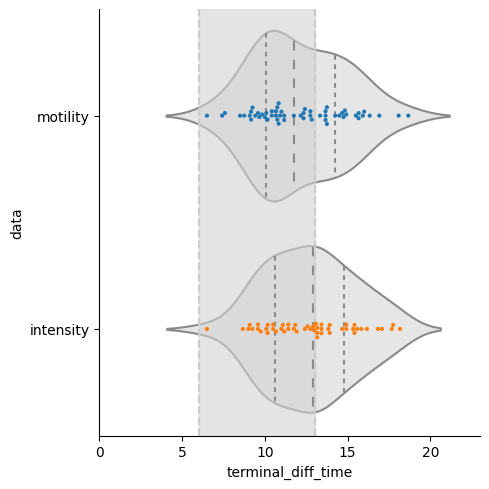

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


number of cells in the analysis: 71
: normality test p-val=0.14073451388676728, mean: 15.366, std: 1.88, median: 15.0, percentage >=0: 100.0 %


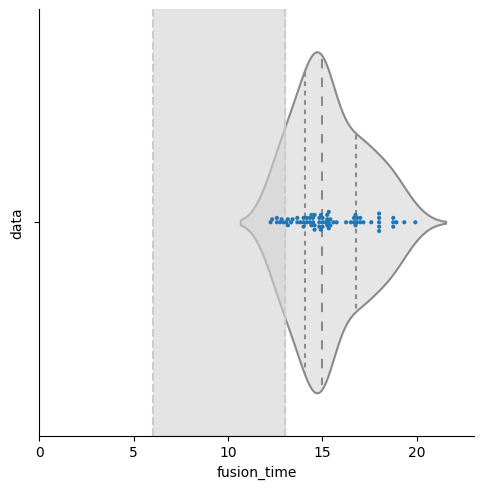

In [6]:
def plot_violin_distributions(data, feature, modalities, plot_window=False, xlim=None):
    print(f"number of cells in the analysis: {data['Spot track ID'].nunique()}")
    df = pd.DataFrame()
    medians = []
    for modality in modalities:
        col = f"{feature}_{modality}".rstrip('_')
        p_value = normaltest(data[col], nan_policy='omit')[1]
        mean = round(data[col].mean(), 3)
        std = round(data[col].std(), 3)
        median = round(data[col].median(), 3)
        medians.append(median)
        percentage_zero_above = round(
            100 * (len(data[data[col] > 0]) / len(data)), 3)

        print(
            f"{modality}: normality test p-val={p_value}, mean: {mean}, std: {std}, median: {median}, percentage >=0: {percentage_zero_above} %")
        df = df.append(pd.DataFrame({feature: data[col], "data": modality}),
                       ignore_index=True)

    sns.catplot(data=df, x=feature, y="data", kind="violin", color=".9", inner="quartile")
    sns.swarmplot(data=df, x=feature, y="data", size=3)
    
    if xlim:
        plt.xlim(xlim)
    if plot_window:
        plt.axvspan(6, 13, alpha=0.6, color='lightgray')
        plt.axvline(6, color=".8", linestyle='dashed')
        plt.axvline(13, color=".8", linestyle='dashed')
    plt.savefig(consts.storage_path + f"eps_figs/dist_{feature}_{str(modalities)}.eps", format="eps")

    plt.show()
    
utils.plot_violin_distributions(scores_df_s3.drop_duplicates("Spot track ID"), "terminal_diff_time", ["motility", "intensity"], plot_window=True, xlim=(0, 23))
utils.plot_violin_distributions(scores_df_s3.drop_duplicates("Spot track ID"), "fusion_time", [""], plot_window=True, xlim=(0, 23))

number of cells in the analysis: 71
motility: normality test p-val=0.08730318891322314, mean: 3.61, std: 2.491, median: 3.083, percentage >=0: 80.282 %
intensity: normality test p-val=0.13422641610283906, mean: 3.033, std: 1.899, median: 3.0, percentage >=0: 69.014 %


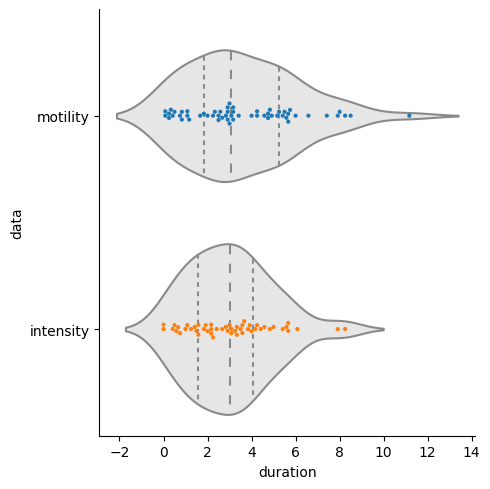

In [7]:
utils.plot_violin_distributions(scores_df_s3.drop_duplicates("Spot track ID"), "duration", ["motility", "intensity"], plot_window=False)

In [13]:
def plot_corr(data, x_col):
    data = data.dropna(subset=[x_col])
    y_col = "fusion_time"

    plt.scatter(data[x_col], data[y_col])

    m, b = np.polyfit(data[x_col], data[y_col], 1)
    plt.plot(data[x_col], m * data[x_col] + b)
    
    coeff, p_val = scipy.stats.pearsonr(data[x_col], data[y_col])
    print("# of cells in the analysis: ", data["Spot track ID"].nunique())
    print("pearson correlation: coeff: ", round(coeff, 2), " p-value: ", p_val)

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()
    
def get_terminal_diff_time(scores_df, modality, diff_threshold):
    def calc_terminal_diff_time(track, modality, diff_threshold):
        terminal_diff_time = get_terminal_differentiation_time(track, modality, diff_threshold)
        return terminal_diff_time

    def map_terminal_diff_time(x, persistence_lst):
        return persistence_lst[x.iloc[0]]

    terminal_diff_time_lst = scores_df.groupby(['Spot track ID']).apply(
        lambda x: calc_terminal_diff_time(x, modality, diff_threshold))
    scores_df[f"terminal_diff_time_{modality}"] = scores_df.groupby(['Spot track ID'])['Spot track ID'].transform(
        lambda x: map_terminal_diff_time(x, terminal_diff_time_lst))

    return scores_df

# of cells in the analysis:  57
pearson correlation: coeff:  0.49  p-value:  0.0


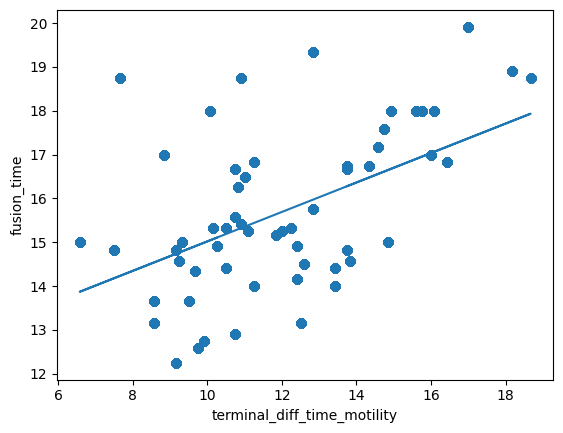

# of cells in the analysis:  51
pearson correlation: coeff:  0.7  p-value:  0.0


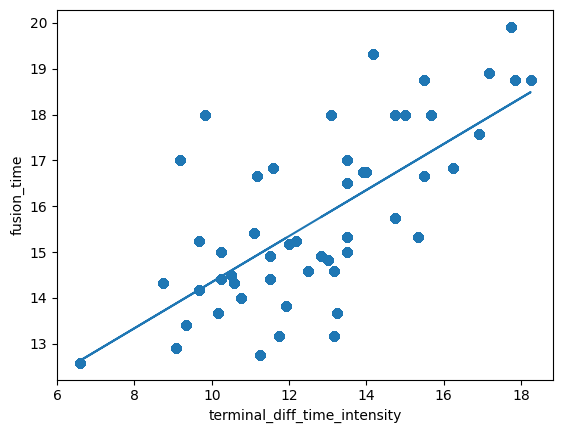

In [54]:
def get_terminal_differentiation_time(track_df, modality, diff_threshold=0.78):
    track_df = track_df[(track_df["time"] <= track_df["fusion_time"])]
    track_df = track_df.sort_values("Spot frame", ascending=True)
    high_then_thresh = track_df[(track_df[f"score_{modality}"] >= diff_threshold)]
    high_then_thresh["Spot frame diff"] = high_then_thresh["Spot frame"].diff()
    
    longest_sequence = calculator.get_longest_sequences(high_then_thresh)
    if longest_sequence is None:
        diff_time = np.nan
    else:
        diff_frame = np.floor(longest_sequence["Spot frame"].min())
        diff_time = diff_frame * 1 / 12
    return diff_time


scores_df_s3 = calculator.get_terminal_diff_time(scores_df_s3, "motility", 0.78)
scores_df_s3 = calculator.get_terminal_diff_time(scores_df_s3, "intensity", 0.78)
plot_corr(scores_df_s3, "terminal_diff_time_motility")
plot_corr(scores_df_s3, "terminal_diff_time_intensity")